In [1]:
# UNCOMMENT AND RUN IF YOU NEED TO RESIZE THE IMAGES I'M USING 64x64 TO SAVE GPU MEMORY

# from PIL import Image

# keys = list(labels.keys())

# for idx in tqdm.tqdm(range(len(keys))):
#   image = Image.open('./data/images/' + keys[idx])
#   new_image = image.resize((64, 64))
#   new_image.save('./data/images/' + keys[idx])

In [2]:
# RUN IF YOU NEED TO CONVERT IMAGES TO GRAYSCALE SOME IMAGES WERE NOT GRAYSCALE

# from PIL import Image
# keys = list(labels.keys())

# for idx in tqdm.tqdm(range(len(keys))):
#   img = Image.open('./data/images/' + keys[idx]).convert('LA')
#   img.save('./data/images/' + keys[idx])

In [3]:
# import requests

# def download_file_from_google_drive(id, destination):
#     URL = "https://docs.google.com/uc?export=download"

#     session = requests.Session()

#     response = session.get(URL, params = { 'id' : id }, stream = True)
#     token = get_confirm_token(response)

#     if token:
#         params = { 'id' : id, 'confirm' : token }
#         response = session.get(URL, params = params, stream = True)

#     save_response_content(response, destination)    

# def get_confirm_token(response):
#     for key, value in response.cookies.items():
#         if key.startswith('download_warning'):
#             return value

#     return None

# def save_response_content(response, destination):
#     CHUNK_SIZE = 32768

#     with open(destination, "wb") as f:
#         for chunk in response.iter_content(CHUNK_SIZE):
#             if chunk: # filter out keep-alive new chunks
#                 f.write(chunk)

In [4]:
# TRAIN_VAL_ID = '1WEADvNr4A6rxLwTgPzNBrzgD2cIj6r5j'
# TEST_ID = '1deoCWp-0LBAEAHjfQr-h7OZQS8eTuR9Y'
# TRAIN_VAL_FILE = './train_val.txt'
# TEST_FILE = './test.txt'

# download_file_from_google_drive(TRAIN_VAL_ID, TRAIN_VAL_FILE)
# download_file_from_google_drive(TEST_ID, TEST_FILE)

In [5]:
# with open(TRAIN_VAL_FILE) as f:
#     file_names = [line.rstrip() for line in f]

In [6]:
# with open(TEST_FILE) as f:
#     for line in f:
#         file_names.append(line.rstrip())

In [7]:
# import pandas as pd

# CHUNK_SIZE = 10000
# LABEL_FILE = './labels/Data_Entry_2017.csv'
# chunk = pd.read_csv(LABEL_FILE,chunksize=CHUNK_SIZE, usecols=["Image Index", "Finding Labels"])
# pd_df = pd.concat(chunk)

In [8]:
# import tqdm

# HEALTHY_LABEL = 'No Finding'
# labels = {}

# for idx in tqdm.tqdm(range(len(file_names))):
#     if pd_df[pd_df['Image Index'] == file_names[idx]]['Finding Labels'].values[0] == HEALTHY_LABEL:
#         labels[file_names[idx]] = 'healthy'
#     else:
#         labels[file_names[idx]] = 'unhealthy'

In [9]:
# import os
# keys = list(labels.keys())

# for idx in tqdm.tqdm(range(len(keys))):
#     file = keys[idx]
#     os.rename('./data/images/'+file, './data/' + labels[file] + '/' + file)

In [10]:
# os.rmdir('./data/images')

In [11]:
import tensorflow as tf

data_dir = './data'
BATCH_SIZE = 64
img_height = 64
img_width = 64

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)


train_ds = train_datagen.flow_from_directory(
        data_dir,
        target_size=(img_width, img_height),
        batch_size=BATCH_SIZE,
        class_mode="binary",
        color_mode="grayscale")

Found 112120 images belonging to 2 classes.


In [12]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    model.add(tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

In [13]:
def make_discriminator_model():
    in_label = tf.keras.layers.Input(shape=(1,))
    li = tf.keras.layers.Embedding(2, 50)(in_label)
    n_nodes = 64 * 64
    
    li = tf.keras.layers.Dense(n_nodes)(li)
    li = tf.keras.layers.Reshape((64, 64, 1))(li)
    
    in_image = tf.keras.layers.Input(shape=(64, 64, 1))
    merge = tf.keras.layers.Concatenate()([in_image, li])
    
    fe = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(merge)
    fe = tf.keras.layers.LeakyReLU()(fe)
    fe = tf.keras.layers.Dropout(0.3)(fe)

    fe = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(fe)
    fe = tf.keras.layers.LeakyReLU()(fe)
    fe = tf.keras.layers.Dropout(0.3)(fe)
    
    fe = tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')(fe)
    fe = tf.keras.layers.LeakyReLU()(fe)
    fe = tf.keras.layers.Dropout(0.3)(fe)

    fe = tf.keras.layers.Flatten()(fe)
    out_layer = tf.keras.layers.Dense(1)(fe)
    
    model = tf.keras.models.Model([in_image, in_label], out_layer)
    return model

In [14]:
def make_generator_model():
    in_label = tf.keras.layers.Input(shape=(1,))
    li = tf.keras.layers.Embedding(2, 50)(in_label)
    
    n_nodes = 2 * 2
    
    li = tf.keras.layers.Dense(n_nodes)(li)
    
    li = tf.keras.layers.Reshape((2, 2, 1))(li)
    
    in_lat = tf.keras.layers.Input(shape=(100,))
    
    n_nodes = 256 * 2 * 2
    
    gen = tf.keras.layers.Dense(n_nodes)(in_lat)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    gen = tf.keras.layers.Reshape((2, 2, 256))(gen)
    
    merge = tf.keras.layers.Concatenate()([gen, li])
    
    gen = tf.keras.layers.Dense(2*2*64, use_bias=False, input_shape=(100,))(merge)
    gen = tf.keras.layers.BatchNormalization()(gen)
    gen = tf.keras.layers.LeakyReLU()(gen)

    gen = tf.keras.layers.Reshape((2, 2, 256))(gen)
    
    gen = tf.keras.layers.Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='same', use_bias=False)(gen)
    gen = tf.keras.layers.BatchNormalization()(gen)
    gen = tf.keras.layers.ReLU()(gen)
    print(gen.shape)

    gen = tf.keras.layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False)(gen)
    gen = tf.keras.layers.BatchNormalization()(gen)
    gen = tf.keras.layers.ReLU()(gen)
    print(gen.shape)

    gen = tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False)(gen)
    gen = tf.keras.layers.BatchNormalization()(gen)
    gen = tf.keras.layers.ReLU()(gen)
    print(gen.shape)

    gen = tf.keras.layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False)(gen)
    gen = tf.keras.layers.BatchNormalization()(gen)
    gen = tf.keras.layers.ReLU()(gen)
    print(gen.shape)
    
    gen = tf.keras.layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False)(gen)
    gen = tf.keras.layers.BatchNormalization()(gen)
    gen = tf.keras.layers.ReLU()(gen)
    print(gen.shape)

    gen = tf.keras.layers.Conv2DTranspose(1, (4, 4), strides=(2, 2), padding='same', use_bias=False)(gen)
    out_layer = tf.keras.layers.Activation(activation='tanh')(gen)
    print(out_layer.shape)
    
    model = tf.keras.models.Model([in_lat, in_label], out_layer)
    return model

In [15]:
# generator = make_generator_model()
# from numpy.random import randint

# labels = tf.convert_to_tensor(randint(0, 2, 64).astype('float32'))
# seed = tf.random.normal([64, 100])
# generator([seed, labels], training=False).shape

In [16]:
discriminator = make_discriminator_model()
generator = make_generator_model()

(None, 2, 2, 512)
(None, 4, 4, 256)
(None, 8, 8, 128)
(None, 16, 16, 64)
(None, 32, 32, 32)
(None, 64, 64, 1)


In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [18]:
from numpy.random import randint
EPOCHS = 10

@tf.function
def train_step(images, labels):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_labels = tf.convert_to_tensor(randint(0, 2, BATCH_SIZE).astype('float32'))
        generated_images = generator([noise, fake_labels], training=True)
        
        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, fake_labels], training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return real_output, fake_output, gen_loss, disc_loss

def train(dataset, epochs):
    epoch = 0
    for epoch in range(epochs):
        i = 0
        for image_batch, labels in dataset:
            i += 1
            real_output, fake_output, gen_loss, disc_loss = train_step(image_batch, labels)
            if i % 50 == 0:
                tf.print('[%d/%d][%d/%d] D(x) = %s D(G(z)) = %s G loss: %s D loss: %s' % 
                         (epoch+1, EPOCHS, i, len(dataset),
                          str(tf.math.sigmoid(real_output).numpy().mean()), 
                          str(tf.math.sigmoid(fake_output).numpy().mean()),
                          str(gen_loss.numpy()),
                          str(disc_loss.numpy())
                         ))
            if i == len(dataset):
                break

In [19]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [51]:
#checkpoint.restore(checkpoint_dir + '/ckpt-1')

In [52]:
seed = tf.random.normal([1, 100])
labels = tf.convert_to_tensor(randint(0, 2, 1).astype('float32'))

In [53]:
#generator.load_weights('./checkpoints/my_checkpoint')

In [54]:
import matplotlib.pyplot as plt

predictions = generator([seed, labels], training=False)
real, _ = train_ds[0]
real = real[0].squeeze(2)

In [55]:
image = predictions[0]

In [56]:
image = image.numpy()

In [57]:
image = image.squeeze(2)

In [58]:
image = image * 255

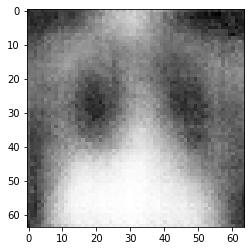

In [59]:
plt.imshow(image, cmap='gray')

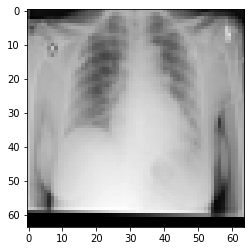

In [60]:
plt.imshow(real, cmap='gray')